## Introduction

In this next notebook, I'll take the cleaned wildfire data, join it with more granular weather data, and then create a multiple linear regression model to predict the size of wildfires based on weather and location data.

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas as gpd
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

#### Importing Data

In [2]:
#MTBS Data
mtbs = pd.read_csv('MTBS_clean.csv')
mtbs.drop(columns='Unnamed: 0', inplace=True)

In [3]:
#Monitor Data
monitors = pd.read_csv('Monitor_by_Region.csv')

In [4]:
#Ecoregion Level 3 - Weather Data
weather = pd.read_csv('Ecoregion Level 3 Weather.csv', skiprows=[1])
weather.drop(columns='Unnamed: 0', inplace=True)

## Modeling - 1

#### Joining Data

In [5]:
#Converting to date
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
mtbs['Date'] = pd.to_datetime(mtbs['Date'], format='%Y-%m-%d')

In [6]:
#Joining Data
mtbs_weather_3 = pd.merge(mtbs, weather, how='left', on=['NA_L3NAME', 'Date'])
mtbs_weather_3.drop(columns=['wind_speed_ms_30', 'wind_speed_ms_90', 'wind_speed_ms_180', 'wind_speed_ms_365'],
                   inplace=True)
mtbs_weather_3.dropna(inplace=True)

#### Preprocessing Data

In [7]:
def preprocess(list_df, cols, target='Acres'):
    """This function will be used to preprocess the data everytime we'd like to change the characteristics of the data
    we're modeling.
    
    Parameters:
    list_df - list of dataframes to be processed
    cols - list of columns to keep
    target - our target variable, 'Acres'
    """
    
    targets = []
    predictors = []
    
    for df in list_df:
        targets.append(df[target])
        df1 = df[cols]
        predictors.append(pd.get_dummies(df1, drop_first=True))
    
    return targets, predictors

### Round 1 - Full Dataset

In [8]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L3NAME', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_1, predictors_1 = preprocess([mtbs_weather_3], col_keep)

In [9]:
#Correlation Matrix
corr_df = pd.DataFrame(predictors_1[0].corr()[abs(predictors_1[0].corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value
738,NA_L3NAME_Southeastern Plains,precipitation_cm_90,0.813436
2110,state_NJ,NA_L3NAME_Atlantic Coastal Pine Barrens,0.990339
5288,state_KS,NA_L3NAME_Flint Hills,0.829366
7304,state_PA,NA_L3NAME_North Central Appalachians,0.801692
8887,state_MO,NA_L3NAME_Ozark Highlands,0.833715
9714,precipitation_cm_90,NA_L3NAME_Southeastern Plains,0.813436
13472,NA_L3NAME_Flint Hills,state_KS,0.829366
14563,NA_L3NAME_Ozark Highlands,state_MO,0.833715
15310,NA_L3NAME_Atlantic Coastal Pine Barrens,state_NJ,0.990339
16280,NA_L3NAME_North Central Appalachians,state_PA,0.801692


In [10]:
colin_check = pd.concat([predictors_1[0][['state_NJ', 'state_KS', 'state_PA', 'state_MO',
                                          'NA_L3NAME_Flint Hills', 
                                          'NA_L3NAME_Ozark Highlands',
                                          'NA_L3NAME_Atlantic Coastal Pine Barrens',
                                          'NA_L3NAME_North Central Appalachians',
                                          'NA_L3NAME_Southeastern Plains', 'precipitation_cm_90']],
                         target_1[0]], axis=1)
colin_check.corr()

,state_NJ,state_KS,state_PA,state_MO,NA_L3NAME_Flint Hills,NA_L3NAME_Ozark Highlands,NA_L3NAME_Atlantic Coastal Pine Barrens,NA_L3NAME_North Central Appalachians,NA_L3NAME_Southeastern Plains,precipitation_cm_90,Acres
state_NJ,1.000000,-0.020182,-0.001747,-0.007224,-0.018841,-0.008516,0.990339,-0.001400,-0.017659,-0.014701,-0.014173
state_KS,-0.020182,1.000000,-0.007389,-0.030559,0.829366,-0.036027,-0.020182,-0.005924,-0.074707,-0.137570,0.002013
state_PA,-0.001747,-0.007389,1.000000,-0.002645,-0.006899,-0.003118,-0.001747,0.801692,-0.006466,-0.004740,-0.005355
state_MO,-0.007224,-0.030559,-0.002645,1.000000,-0.028529,0.833715,-0.007224,-0.002120,-0.026740,0.001380,-0.021555
NA_L3NAME_Flint Hills,-0.018841,0.829366,-0.006899,-0.028529,1.000000,-0.033633,-0.018841,-0.005531,-0.069744,-0.165827,0.002868
NA_L3NAME_Ozark Highlands,-0.008516,-0.036027,-0.003118,0.833715,-0.033633,1.000000,-0.008516,-0.002500,-0.031524,0.000042,-0.024770
NA_L3NAME_Atlantic Coastal Pine Barrens,0.990339,-0.020182,-0.001747,-0.007224,-0.018841,-0.008516,1.000000,-0.001400,-0.017659,-0.015560,-0.014157
NA_L3NAME_North Central Appalachians,-0.001400,-0.005924,0.801692,-0.002120,-0.005531,-0.002500,-0.001400,1.000000,-0.005184,-0.008029,-0.004077
NA_L3NAME_Southeastern Plains,-0.017659,-0.074707,-0.006466,-0.026740,-0.069744,-0.031524,-0.017659,-0.005184,1.000000,0.813436,-0.052840
precipitation_cm_90,-0.014701,-0.137570,-0.004740,0.001380,-0.165827,0.000042,-0.015560,-0.008029,0.813436,1.000000,-0.096469


In [11]:
predictors_1[0].drop(columns=['state_MO', 'state_KS', 'NA_L3NAME_North Central Appalachians',
                             'NA_L3NAME_Atlantic Coastal Pine Barrens',
                             'NA_L3NAME_Southeastern Plains'], inplace=True)

In [58]:
def ols_modeling(predictors, targets, labels):
    """Use OLS Regression modeling and print the results.
    
    Attributes:
    predictors - a list of dataframes containing the predictor variables
    targets - a list of dataframes containing the target variable (Acres)
    labels - a list of labels for each dataframe being modeled"""
    
    for i in range(len(targets)):
        X_train, X_test, y_train, y_test = train_test_split(predictors[i], targets[i], test_size=0.2)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)
        train_mse = mean_squared_error(y_train, y_hat_train)
        test_mse = mean_squared_error(y_test, y_hat_test)
        print(labels[i])
        print('Train Mean Squarred Error:', train_mse)
        print('Test Mean Squarred Error:', test_mse)
        print("R^2 Score: {}".format(model.score(X_test, y_test)))

        plt.figure(figsize=(12,6))
        sns.lineplot(range(len(y_hat_test[:100])), y_hat_test[:100], label='Predicted')
        sns.lineplot(range(len(y_hat_test[:100])), y_test[:100], label='Actual')
    
        plt.title('Predicted Acres Burned vs Actual Acres Burned')
        plt.ylabel('Acres')
        plt.xlabel('Value')
        plt.legend()
        plt.show()

Full Dataset
Train Mean Squarred Error: 575614331.9772909
Test Mean Squarred Error: 462909205.1784692
R^2 Score: 0.036796671477018816


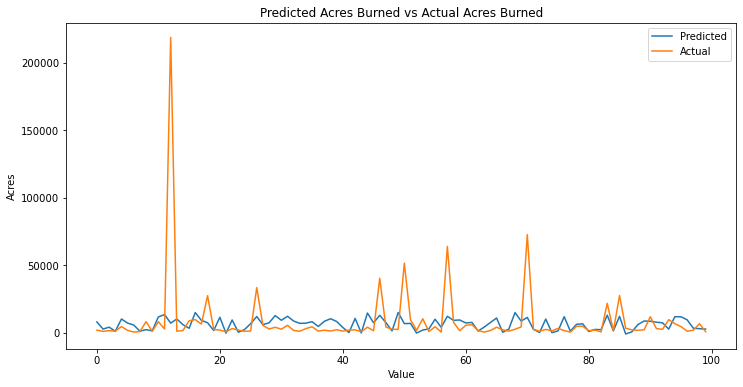

In [62]:
ols_modeling(predictors_1, target_1, ['Full Dataset'])

### Round 2 - Dropping States

In [63]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L3NAME', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_2, predictors_2 = preprocess([mtbs_weather_3], col_keep)

No States
Train Mean Squarred Error: 524316503.90494114
Test Mean Squarred Error: 675489393.1656048
R^2 Score: 0.012565293784587372


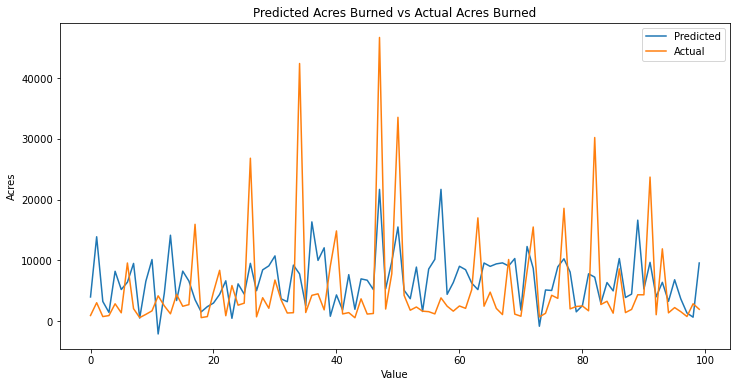

In [64]:
ols_modeling(predictors_2, target_2, ['No States'])

### Round 3 - Narrowing List of Ecoregions

In [65]:
a = mtbs_weather_3['NA_L3NAME'].value_counts().to_frame().reset_index()
ecoregions_400 = list(a[a['NA_L3NAME'] > 400]['index'])

In [66]:
regions_over_400 = mtbs_weather_3[mtbs_weather_3['NA_L3NAME'].isin(ecoregions_400)]

In [67]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L3NAME', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_3, predictors_3 = preprocess([regions_over_400], col_keep)

Ecoregions with more than 400 Fires
Train Mean Squarred Error: 447736829.1117643
Test Mean Squarred Error: 1373231502.5129857
R^2 Score: 0.009932125734912756


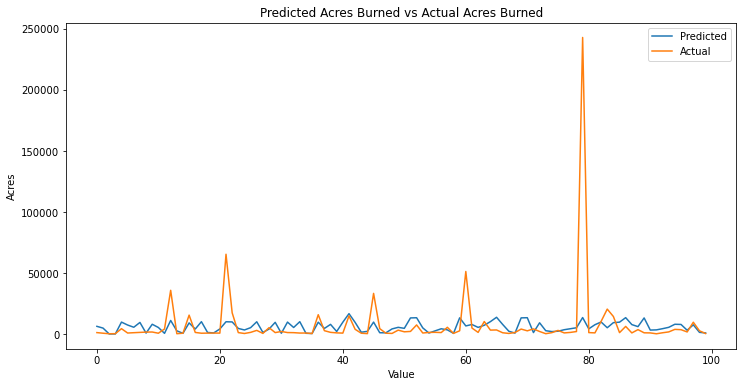

In [68]:
ols_modeling(predictors_3, target_3, ['Ecoregions with more than 400 Fires'])

### Round 4 - No Ecoregions

In [69]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_4, predictors_4 = preprocess([mtbs_weather_3], col_keep)

No Ecoregions
Train Mean Squarred Error: 483415910.21445274
Test Mean Squarred Error: 852532378.1888372
R^2 Score: 0.015075112104816046


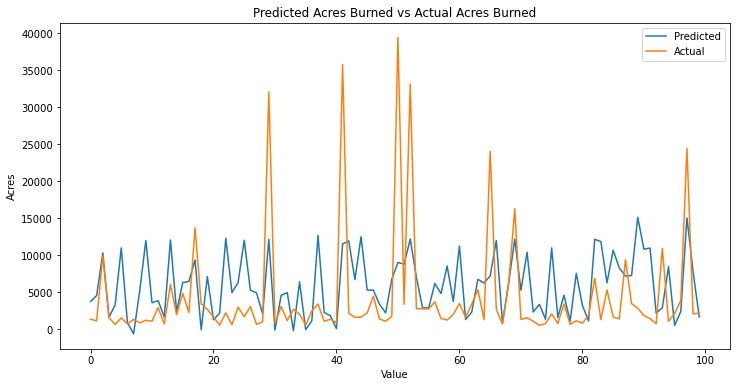

In [70]:
ols_modeling(predictors_4, target_4, ['No Ecoregions'])

### Round 5 - Narrowing List of States

In [71]:
a = mtbs_weather_3['state'].value_counts().to_frame().reset_index()
states_400 = list(a[a['state'] > 400]['index'])

In [72]:
states_over_400 = mtbs_weather_3[mtbs_weather_3['state'].isin(states_400)]

In [73]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_5, predictors_5 = preprocess([states_over_400], col_keep)

States with more than 400 Fires
Train Mean Squarred Error: 623501129.6193179
Test Mean Squarred Error: 581609222.6728802
R^2 Score: 0.03012001748485782


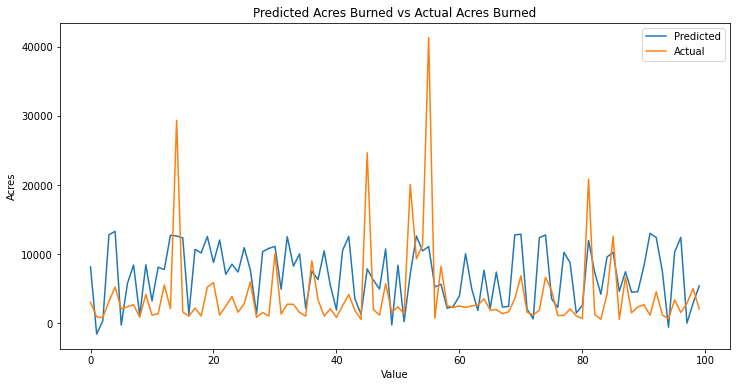

In [74]:
ols_modeling(predictors_5, target_5, ['States with more than 400 Fires'])

### Round 6 - Splitting into different time frames

In [75]:
start_1990 = mtbs_weather_3[mtbs_weather_3['Date'] < '1990-01-01']
bwtn_1990_2000 = mtbs_weather_3[(mtbs_weather_3['Date'] >= '1990-01-01') & (mtbs_weather_3['Date'] < '2000-01-01')]
bwtn_2000_2010 = mtbs_weather_3[(mtbs_weather_3['Date'] >= '2000-01-01') & (mtbs_weather_3['Date'] < '2010-01-01')]
after_2010 = mtbs_weather_3[mtbs_weather_3['Date'] >= '2010-01-01']

date_range_dfs = [start_1990, bwtn_1990_2000, bwtn_2000_2010, after_2010]

In [76]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L3NAME','state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_6, predictors_6 = preprocess(date_range_dfs, col_keep)

Before 1990
Train Mean Squarred Error: 452321162.9834633
Test Mean Squarred Error: 174066886.6740302
R^2 Score: -0.3587085072410885


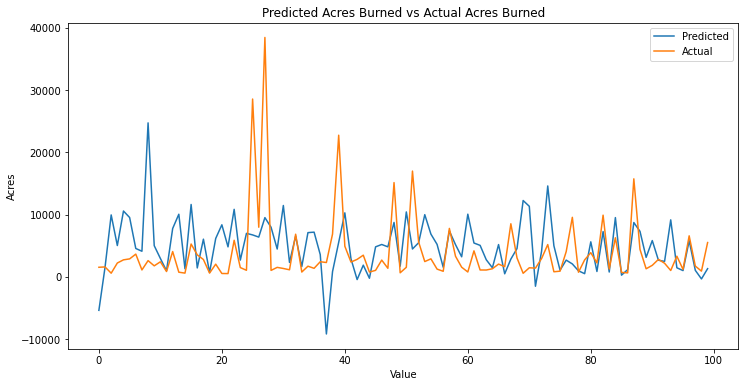

1990-2000
Train Mean Squarred Error: 167390218.25644097
Test Mean Squarred Error: 272576111.6849046
R^2 Score: 0.035884155748598046


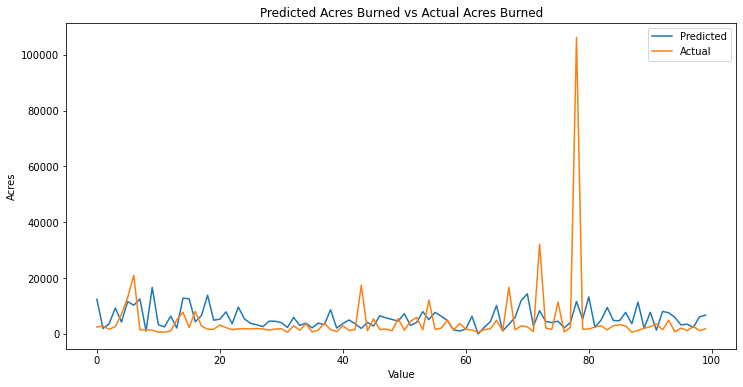

2000-2010
Train Mean Squarred Error: 955084686.8913425
Test Mean Squarred Error: 341018592.52262425
R^2 Score: -0.06264866120588408


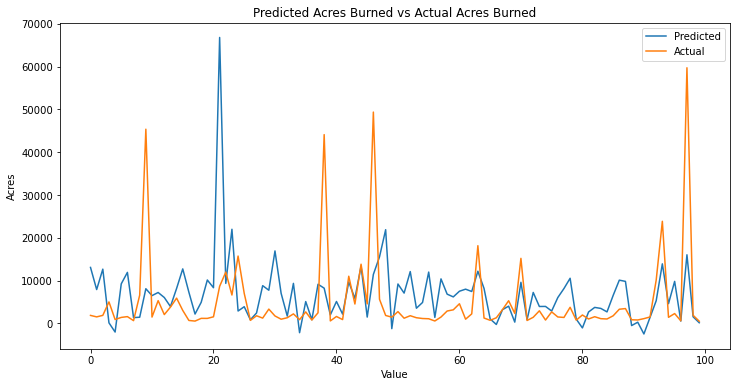

After 2010
Train Mean Squarred Error: 483627100.314951
Test Mean Squarred Error: 473494732.56045884
R^2 Score: 0.07488415201260812


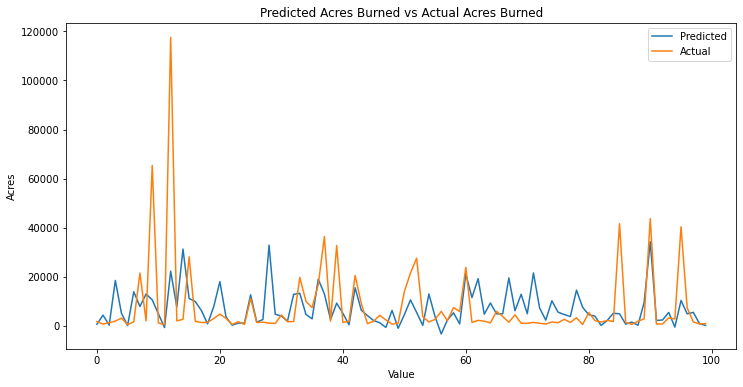

In [77]:
ols_modeling(predictors_6, target_6, ['Before 1990', '1990-2000', '2000-2010', 'After 2010'])

### Round 7 - Splitting into different sizes

In [78]:
under_5k = mtbs_weather_3[mtbs_weather_3['Acres'] < 5000]
bwtn_5k_50k = mtbs_weather_3[(mtbs_weather_3['Acres'] >= 5000) & (mtbs_weather_3['Acres'] < 50000)]
over_50k = mtbs_weather_3[mtbs_weather_3['Acres'] >= 50000]

acre_range_dfs = [under_5k, bwtn_5k_50k, over_50k]

In [79]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L3NAME','state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_7, predictors_7 = preprocess(acre_range_dfs, col_keep)

Under 5K
Train Mean Squarred Error: 1004023.4340850244
Test Mean Squarred Error: 1032654.5478995859
R^2 Score: 0.12506353677036852


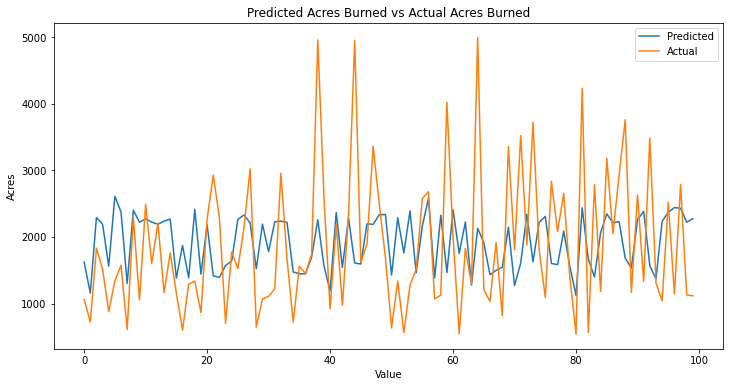

5K to 50K
Train Mean Squarred Error: 87647247.04281346
Test Mean Squarred Error: 93706675.92031805
R^2 Score: 0.03523241893897333


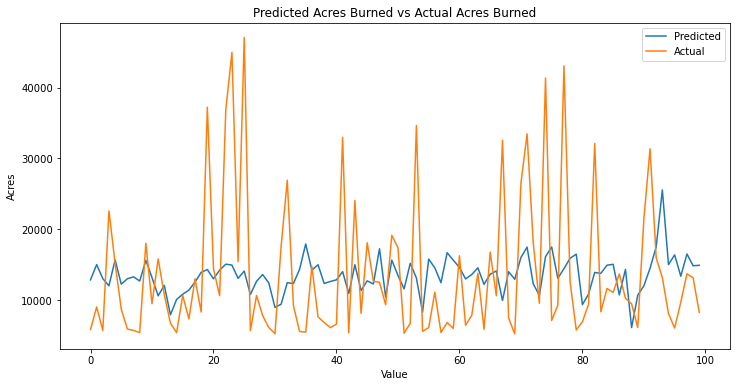

Over 50K
Train Mean Squarred Error: 11348728001.293762
Test Mean Squarred Error: 15388959325.295486
R^2 Score: -0.4308814501239513


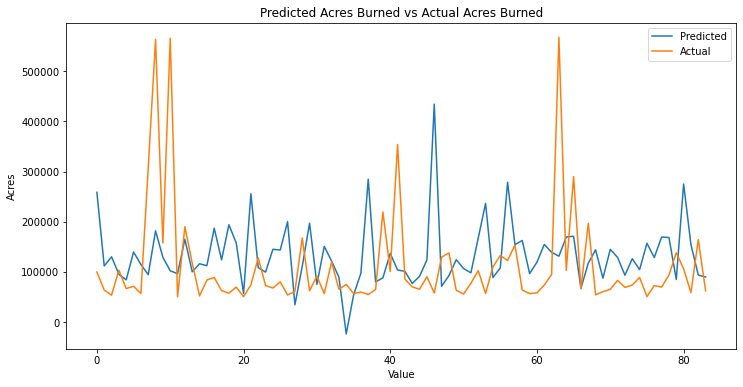

In [80]:
ols_modeling(predictors_7, target_7, ['Under 5K', '5K to 50K', 'Over 50K'])

### Round 8 - Only Wildfires

In [81]:
wfs = mtbs_weather_3[mtbs_weather_3['Fire_Type'] == 'Wildfire']

In [82]:
col_keep = ['NA_L3NAME', 'Low_T', 'Mod_T', 'High_T', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_8, predictors_8 = preprocess([wfs], col_keep)

Only Wildfires
Train Mean Squarred Error: 675588210.2005507
Test Mean Squarred Error: 792966737.4843272
R^2 Score: 0.02684142527640976


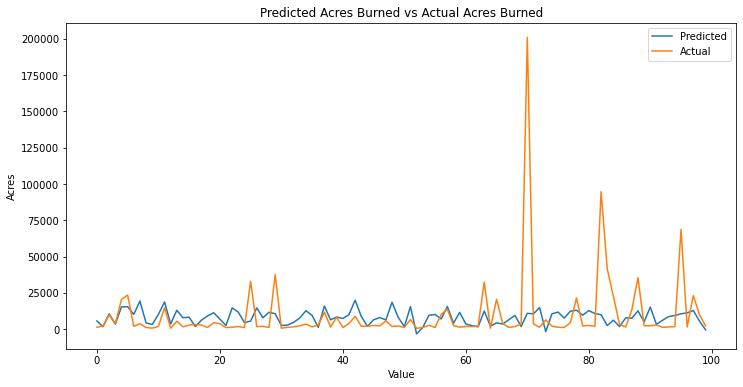

In [83]:
ols_modeling(predictors_8, target_8, ['Only Wildfires'])

#### Model Summary

All of the models generated above showed very little promise. All but a few of them had r-squared values above `0.1` and those that did have r-squared values higher than that weren't much use, as they were models for fires prior to 1990 or larger than 50,000 acres.

## Modeling - 2

Instead of trying to make a model for the whole dataset and using that as a starting point, I'm going to make invidiudal models for the top 3 states with the largest amount of wildfires.

In [84]:
mtbs_weather_3[mtbs_weather_3['Fire_Type'] == 'Wildfire']['state'].value_counts().head()

CA    1555
ID    1337
NV     918
OR     827
TX     820
Name: state, dtype: int64

### California

In [85]:
ca = mtbs_weather_3[(mtbs_weather_3['Fire_Type'] == 'Wildfire') & (mtbs_weather_3['state'] == 'CA')]

In [86]:
col_keep = ['NA_L3NAME', 'Low_T', 'Mod_T', 'High_T', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_ca, predictors_ca = preprocess([ca], col_keep)

California Wildfires
Train Mean Squarred Error: 653525335.5261556
Test Mean Squarred Error: 945942643.626249
R^2 Score: 0.00462526584773848


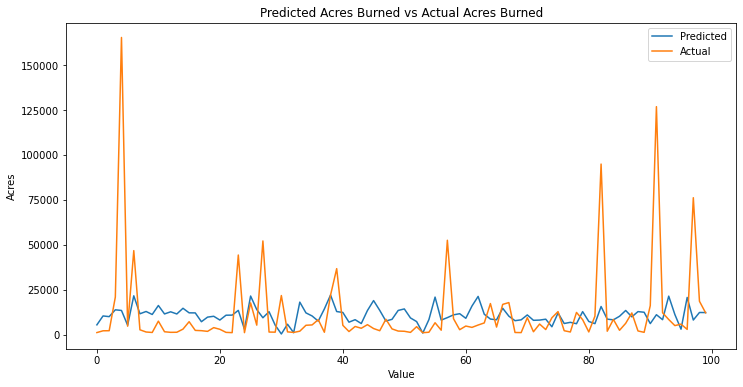

In [87]:
ols_modeling(predictors_ca, target_ca, ['California Wildfires'])

### Idaho

In [88]:
id_ = mtbs_weather_3[(mtbs_weather_3['Fire_Type'] == 'Wildfire') & (mtbs_weather_3['state'] == 'ID')]

In [89]:
col_keep = ['NA_L3NAME', 'Low_T', 'Mod_T', 'High_T', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_id, predictors_id = preprocess([id_], col_keep)

Idaho Wildfires
Train Mean Squarred Error: 1158006071.2369778
Test Mean Squarred Error: 1148750520.0884757
R^2 Score: 0.01620270614876851


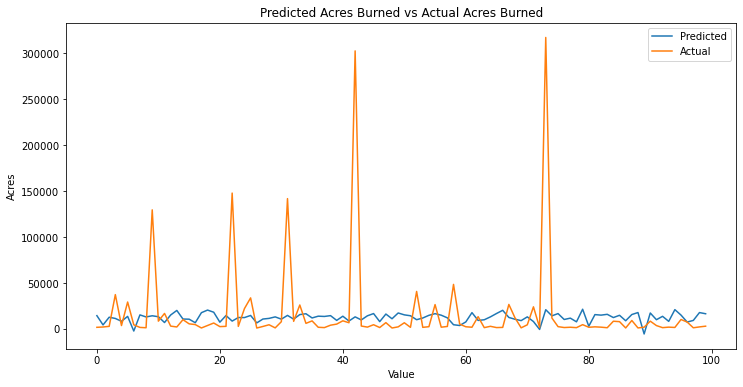

In [90]:
ols_modeling(predictors_id, target_id, ['Idaho Wildfires'])

### Nevada

In [91]:
nv = mtbs_weather_3[(mtbs_weather_3['Fire_Type'] == 'Wildfire') & (mtbs_weather_3['state'] == 'NV')]

In [92]:
col_keep = ['NA_L3NAME', 'Low_T', 'Mod_T', 'High_T', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90']

target_nv, predictors_nv = preprocess([ca], col_keep)

Nevada Wildfires
Train Mean Squarred Error: 727035774.6178674
Test Mean Squarred Error: 637117062.6066343
R^2 Score: -0.014466423550635987


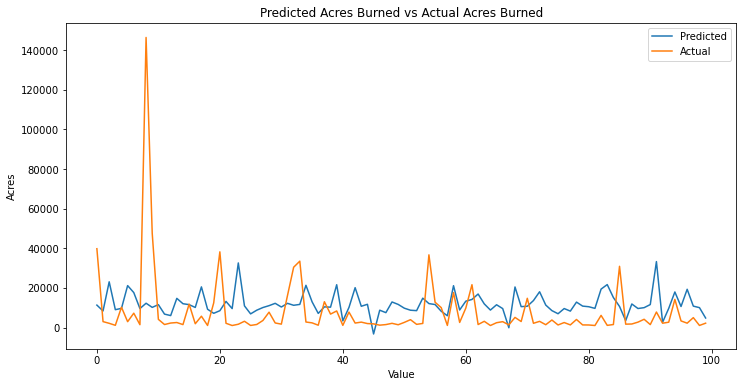

In [93]:
ols_modeling(predictors_nv, target_nv, ['Nevada Wildfires'])